#**Predicting Stock Prices with LSTM using PyTorch**

**Installing and importing the libraries**

In [ ]:
%%capture
!pip install torch=="2.3.0"
!pip install pandas=="2.2.2"
!pip install matplotlib=="3.8.4"
!pip install scikit-learn=="1.4.2"

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Reading and Loading the data**

In [ ]:
url="https://raw.githubusercontent.com/Sai-Manasvi/gold-stock-prediction-using-lstm/refs/heads/main/goldstock.csv"
df = pd.read_csv(url)
df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [ ]:
df.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [ ]:
stock_data = df
# Convert the date column into a Datetime object:
stock_data['Date'] = pd.to_datetime(df.Date)
print("Information about the dataset", end = "\n")
print(stock_data.info())

Information about the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2511 non-null   datetime64[ns]
 1   Close   2511 non-null   float64       
 2   Volume  2511 non-null   float64       
 3   Open    2511 non-null   float64       
 4   High    2511 non-null   float64       
 5   Low     2511 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 117.8 KB
None


In [ ]:
from sklearn.preprocessing import MinMaxScaler
price = stock_data[['High','Low','Open','Close']]
print(price[:5])

     High     Low    Open   Close
0  2041.9  2022.2  2027.4  2029.3
1  2025.6  2007.7  2009.1  2021.6
2  2036.1  2004.6  2031.7  2006.5
3  2062.8  2027.6  2053.4  2030.2
4  2067.3  2033.1  2033.2  2051.6


**Scaling the data**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = scaler.fit_transform(price)
print(price[:5])

[[0.89126026 0.89817334 0.87151213 0.87771921]
 [0.85977789 0.86999611 0.83641768 0.86296119]
 [0.88005794 0.86397202 0.87975837 0.83402012]
 [0.93162723 0.90866693 0.92137309 0.87944418]
 [0.94031869 0.91935484 0.88263496 0.92045999]]


**Training and Test Data Division**

In [ ]:
train_window = 11
import numpy as np
def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(price)
    print('Length = ', L)

    for i in range(L-tw):
        data_seq = price[i:i+tw]
        data_label = price[i+tw:i+tw+1][0][3]
        inout_seq.append((data_seq ,data_label))

    data = inout_seq;
    print('size of data : ', len(data))

    test_set_size = 500
    train_set_size = len(data) - (test_set_size);
    print('size of test : ', test_set_size)
    print('size of train : ', train_set_size)

    train = data[:train_set_size]
    test = data[train_set_size:]
    train = train[:-(tw-1)]
    return train, test

train,test = create_in_out_sequences(price, train_window)

Length =  2511
size of data :  2500
size of test :  500
size of train :  2000


In [ ]:
print(test[0])
print(train[-1])

(array([[-0.8696282 , -0.86416634, -0.87247099, -0.84973646],
       [-0.8914534 , -0.87738049, -0.87860773, -0.87196933],
       [-0.87696765, -0.87407695, -0.87688177, -0.87254432],
       [-0.87252535, -0.86436067, -0.86825199, -0.872161  ],
       [-0.88237566, -0.8789351 , -0.88896347, -0.8639195 ],
       [-0.91018831, -0.89856199, -0.91120913, -0.89324389],
       [-0.92119749, -0.90478041, -0.90392176, -0.91049353],
       [-0.91868662, -0.9084726 , -0.90526417, -0.90685194],
       [-0.90883631, -0.91896619, -0.93134529, -0.89151893],
       [-0.9385804 , -0.92868247, -0.92808515, -0.92429324],
       [-0.94089812, -0.915274  , -0.92750983, -0.92122664]]), -0.9540009583133684)
(array([[-0.70700145, -0.70695686, -0.7115735 , -0.68988979],
       [-0.66470304, -0.71609017, -0.69719053, -0.696023  ],
       [-0.66470304, -0.67042363, -0.64560361, -0.63622425],
       [-0.61139546, -0.70676253, -0.72001151, -0.62012458],
       [-0.73848382, -0.73532841, -0.7349698 , -0.72208912],

**LSTM Class**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                       torch.zeros(1,1,self.hidden_layer_size))
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
from tqdm import tqdm
import torch
import numpy as np

epochs = 10
for i in tqdm(range(epochs), desc="Epoch Progress"):
    epoch_loss = 0
    for seq, labels in train:  # Removed tqdm from here
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)

        labels = labels.view(1)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i:3} loss: {average_loss:.10f}')

Epoch Progress:  10%|█         | 1/10 [00:06<00:58,  6.54s/it]

epoch:   0 loss: 0.0032208957


Epoch Progress:  20%|██        | 2/10 [00:14<00:56,  7.09s/it]

epoch:   1 loss: 0.0029006974


Epoch Progress:  30%|███       | 3/10 [00:22<00:52,  7.54s/it]

epoch:   2 loss: 0.0018191128


Epoch Progress:  40%|████      | 4/10 [00:27<00:39,  6.57s/it]

epoch:   3 loss: 0.0012100205


Epoch Progress:  50%|█████     | 5/10 [00:33<00:31,  6.31s/it]

epoch:   4 loss: 0.0008723977


Epoch Progress:  60%|██████    | 6/10 [00:37<00:23,  5.85s/it]

epoch:   5 loss: 0.0006495615


Epoch Progress:  70%|███████   | 7/10 [00:43<00:17,  5.87s/it]

epoch:   6 loss: 0.0004818606


Epoch Progress:  80%|████████  | 8/10 [00:50<00:11,  5.96s/it]

epoch:   7 loss: 0.0003756373


Epoch Progress:  90%|█████████ | 9/10 [00:55<00:05,  5.95s/it]

epoch:   8 loss: 0.0003219146


Epoch Progress: 100%|██████████| 10/10 [01:01<00:00,  6.11s/it]

epoch:   9 loss: 0.0002943093


In [ ]:
model.eval()
actual = []
pred = []

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

In [ ]:
pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [ ]:
print(pred)
print(actual)

tensor([-0.9069, -0.9132, -0.9122, -0.8993, -0.8783, -0.8740, -0.8918, -0.9248,
        -0.9320, -0.9514, -0.9621, -0.9458, -0.9433, -0.9378, -0.9318, -0.9344,
        -0.9255, -0.9159, -0.9691, -0.9351, -0.9480, -0.9502, -0.9299, -0.9320,
        -0.9279, -0.9205, -0.9320, -0.9076, -0.9448, -0.9653, -0.9428, -0.9444,
        -0.9588, -0.9361, -0.9322, -0.9307, -0.9285, -0.9092, -0.9182, -0.9379,
        -0.9142, -0.8992, -0.9135, -0.9095, -0.9006, -0.9009, -0.8991, -0.8778,
        -0.8713, -0.8484, -0.8239, -0.8058, -0.7979, -0.7808, -0.7561, -0.7748,
        -0.7710, -0.7717, -0.7756, -0.7624, -0.7689, -0.7620, -0.7506, -0.7480,
        -0.7752, -0.7937, -0.7992, -0.8316, -0.8219, -0.8182, -0.8352, -0.8342,
        -0.8751, -0.8723, -0.8541, -0.8405, -0.8153, -0.8023, -0.8294, -0.8475,
        -0.8359, -0.8270, -0.8386, -0.8606, -0.8834, -0.8860, -0.8840, -0.8815,
        -0.8811, -0.8581, -0.8549, -0.8468, -0.8291, -0.8165, -0.8210, -0.8329,
        -0.8408, -0.8500, -0.8241, -0.79

**Scaler Inversion**

In [ ]:
pred_size = len(pred)
pred_new = scaler.inverse_transform(
    np.hstack((np.zeros((pred_size, 3)), pred.reshape(-1, 1)))
)
print(pred_new[:, 3])

[1098.18258121 1094.88770256 1095.40409686 1102.15727795 1113.07793676
 1115.35853054 1106.06508133 1088.85439472 1085.10426187 1074.94309608
 1069.38432366 1077.8803705  1079.16723568 1082.07356687 1085.15756508
 1083.81901383 1088.48394673 1093.46313224 1065.71069366 1083.46526585
 1076.73889186 1075.56902008 1086.15558531 1085.07720598 1087.23813187
 1091.10423187 1085.08211958 1097.81064048 1078.39433911 1067.69488551
 1079.44516497 1078.5967296  1071.09876519 1082.93095868 1084.9985884
 1085.74041735 1086.90680607 1096.96562596 1092.25939395 1082.00001839
 1094.38101106 1102.20557427 1094.72570931 1096.80975916 1101.47111571
 1101.29313772 1102.2533419  1113.37623571 1116.74348109 1128.71950618
 1141.45807197 1150.90636172 1155.01988316 1163.96620842 1176.84303913
 1167.09057277 1169.05700724 1168.70179763 1166.66722584 1173.56339886
 1170.17189648 1173.79352941 1179.74787759 1181.06347798 1166.86914985
 1157.22080202 1154.35664069 1137.45423572 1142.49869745 1144.47990382
 1135.5

In [ ]:
test_size = len(actual)
actual_new = scaler.inverse_transform(
    np.hstack((np.zeros((test_size, 3)), actual.reshape(-1, 1)))
)

print(actual_new[:, 3])

[1073.60000441 1087.09999134 1085.20001484 1096.20000649 1097.89998711
 1107.79998582 1091.899986   1078.39999907 1075.20000263 1060.19999987
 1059.80000809 1067.99999509 1068.30000447 1075.9000038  1068.30000447
 1074.10000969 1080.59998496 1064.99999454 1049.6        1076.80000085
 1061.60000221 1063.39999632 1075.70000791 1072.00000619 1076.49999147
 1075.29998503 1075.20000263 1084.09999079 1061.20001042 1053.80000699
 1063.50000981 1065.30000392 1056.19998877 1069.7000068  1073.29999503
 1066.59999276 1076.29999558 1077.8999938  1068.69999625 1068.60001386
 1083.59998552 1080.89999435 1081.00000784 1084.90000545 1088.49999367
 1088.10000189 1087.70001011 1104.19999759 1106.1999876  1114.0999963
 1135.90001482 1141.40001065 1147.29999826 1176.09999733 1165.80000684
 1166.19999862 1162.80000629 1166.09998513 1167.09999568 1177.49999966
 1172.7999874  1183.10000899 1187.50001187 1179.79999905 1165.40001506
 1164.49998691 1155.90000813 1144.29999771 1148.70000059 1146.4000012
 1137.59

**Performance Metrics**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_new, pred_new)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2.9498087355941536
Root Mean Squared Error (RMSE): 6.931123083591387


**Visualization**

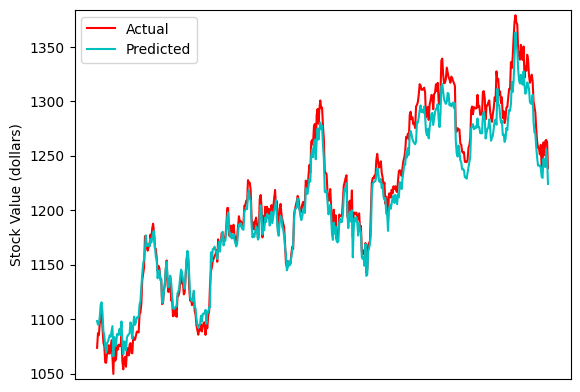

In [ ]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label='Actual')
ax.plot(pred_new[:,3], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')

plt.show()

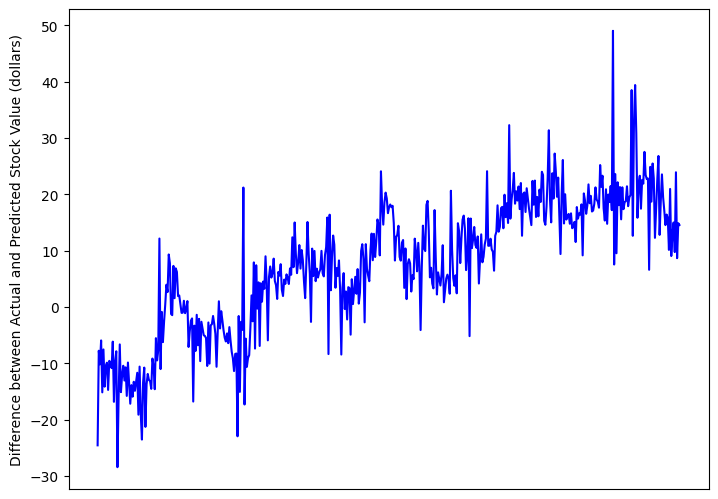

In [ ]:
difference = actual_new - pred_new
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference between Actual and Predicted Stock Value (dollars)')
plt.xticks([])
plt.show()